<img src="media/AE.png" alt="" width="50%" align="right"/></img>

# Conditional VAE for distribution generation

### Autoencoders (AE)
Main use: dimensionality reduction, data representation.

Not useful for: data generation (no restriction on/knowrledge about the structure of the latent space)

[img source](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)


&nbsp;
<img src="media/VAE.png" alt="" width="50%" align="right"/></img>

### Variational autoencoders (VAE)

Main use: data generation, deep fake.

KL-divergence loss part enforces the latent distribution to be close to N(0,1)

[img source](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)


We could improve on VAE by giving some additional information to encoder and decoder (conditioning):


&nbsp;
&nbsp;
&nbsp;
 

### Conditional VAE (CVAE)

<img src="media/cvae_diagram.svg" alt="" width="60%"/></img>

[img source](https://ijdykeman.github.io/ml/2016/12/21/cvae.html)


## Aims: 
- get better understanding of cvae
- use CVAE to sample from complicated distributions, e.g. trajectories of stochastic processes or distributions arising in Bayesian interference

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

from gen_data import cvae_ds, trajectory, stationary
from model import CVAE
from config import params
from train import train

np.random.seed(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## One parameter distributions on R

### Normal; fixed variance, conditioning on mean

In [31]:
par = params.copy()
par.update({
    'input_dim': 1,
    'cond_dim': 1, 
    'epochs': 50,
    'reg': torch.tensor(1),
    'latent_dim': 2,
    'layers': [50,10],
    'train_samples': 10000,
    'batch_size': 100,
    'sigma': 5,
})


M = [np.random.uniform(2,8, par['train_samples']), np.random.uniform(-5,5, par['train_samples'])]
for i, m in enumerate(M):
    s = [ par['sigma'] ] * par['train_samples']
    Y = np.random.normal(m,s)
    set0 = cvae_ds(m, Y)  
    loader = DataLoader(set0, par['batch_size'])

    model = CVAE(device=device, **par).to(device)

    train(model, loader, device, True, **par)

    # save the results
    name = f"data/CVAE_normal_{i}"
    torch.save(model.state_dict(), name+"_model")
    np.save(name+"_params",par)

1: L 29.71431 MSE 25.64247 KLD 4.07184
2: L 5.70672 MSE 2.40229 KLD 3.30443
3: L 3.97846 MSE 1.35608 KLD 2.62238
4: L 3.55289 MSE 1.11936 KLD 2.43353
5: L 3.05339 MSE 0.84244 KLD 2.21096
6: L 2.91544 MSE 0.78039 KLD 2.13505
7: L 2.88154 MSE 0.75840 KLD 2.12314
8: L 2.88550 MSE 0.75851 KLD 2.12699
9: L 2.87479 MSE 0.74768 KLD 2.12711
10: L 2.87194 MSE 0.74877 KLD 2.12318
11: L 2.87472 MSE 0.74977 KLD 2.12496
12: L 2.87788 MSE 0.74655 KLD 2.13133
13: L 2.86076 MSE 0.74031 KLD 2.12045
14: L 2.86840 MSE 0.74582 KLD 2.12258
15: L 2.86645 MSE 0.74317 KLD 2.12328
16: L 2.86105 MSE 0.74107 KLD 2.11998
17: L 2.86538 MSE 0.73918 KLD 2.12619
18: L 2.86976 MSE 0.74501 KLD 2.12476
19: L 2.85390 MSE 0.73434 KLD 2.11956
20: L 2.86364 MSE 0.73823 KLD 2.12541
21: L 2.85589 MSE 0.73765 KLD 2.11824
22: L 2.86032 MSE 0.73682 KLD 2.12351
23: L 2.86608 MSE 0.73861 KLD 2.12747
24: L 2.85076 MSE 0.73411 KLD 2.11665
25: L 2.86106 MSE 0.73501 KLD 2.12606
26: L 2.86130 MSE 0.73578 KLD 2.12552
27: L 2.85324 MSE 0

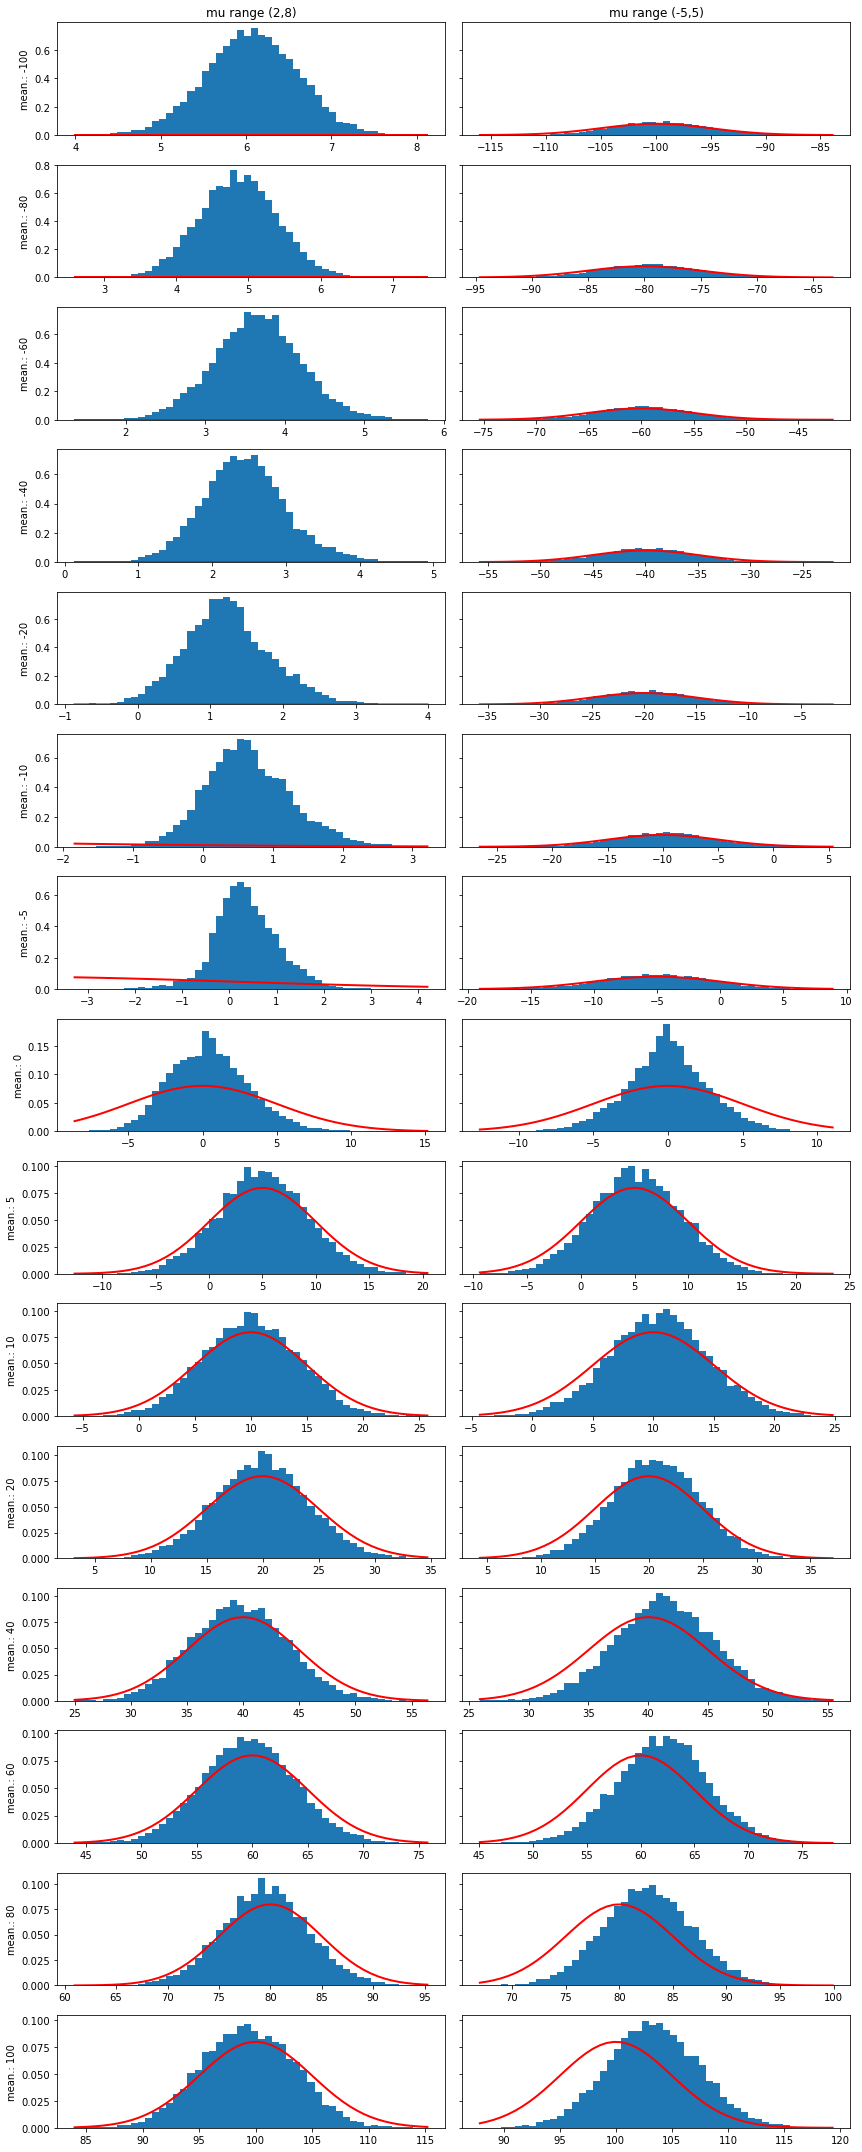

In [32]:
samples = 10000
nrows = 15
ncols = 2
fig, axs = plt.subplots(nrows, ncols,  
                        figsize=(ncols*6, nrows*2),
                        sharey='row')


for i in range(ncols):
    name = f"data/CVAE_normal_{i}"
    par = np.load(name+"_params.npy", allow_pickle=True).item()
    model = CVAE(**par)
    model.load_state_dict(torch.load(name+"_model"))
    
    for j, mean in enumerate(np.concatenate([np.arange(-100,-10,20), 
                                             np.arange(-10,11,5), 
                                             np.arange(20,101,20)])):
        res = model.sample_trajectories(samples, torch.tensor(mean)).squeeze(1)

        count, bins, _ = axs[j,i].hist(res.numpy(), 50, density=1)
        axs[j,i].plot(bins, 1/(par['sigma'] * np.sqrt(2 * np.pi)) *
                       np.exp( - (bins - mean)**2 / (2 * par['sigma']**2) ),
                 linewidth=2, color='r')
        
        axs[j,0].set_ylabel(f"mean.: {mean}")
        
axs[0,0].title.set_text("mu range (2,8)")
axs[0,1].title.set_text("mu range (-5,5)")
fig.tight_layout()
plt.show()

### Exponential conditioning on mean

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

from model import CVAE
from config import params
from train import train
from gen_data import cvae_ds

par = params.copy()
par.update({
    'input_dim': 1,
    'cond_dim': 1, 
    'epochs': 100,
    'reg': torch.tensor(1),
    'end_relu': True,
    'latent_dim': 2,
    'layers': [50,20],
})


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

m = np.random.uniform(2, 5, par['train_samples'])
Y = np.random.exponential(m)
set0 = cvae_ds(m, Y)
loader = DataLoader(set0, par['batch_size'])

model = CVAE(device=device, **par).to(device)

train(model, loader, device, True, **par)

# save the results
name = "data/CVAE_exp"
torch.save(model.state_dict(), name+"_model")
np.save(name+"_params",par)

1: L 11.22553 MSE 9.32600 KLD 1.89953
2: L 2.78243 MSE 0.94360 KLD 1.83883
3: L 2.19504 MSE 0.65079 KLD 1.54426
4: L 2.08683 MSE 0.59555 KLD 1.49128
5: L 2.05564 MSE 0.58098 KLD 1.47467
6: L 2.04675 MSE 0.57543 KLD 1.47132
7: L 2.02306 MSE 0.56035 KLD 1.46271
8: L 2.01774 MSE 0.55850 KLD 1.45924
9: L 2.01461 MSE 0.55407 KLD 1.46054
10: L 2.01305 MSE 0.55542 KLD 1.45763
11: L 2.01150 MSE 0.55054 KLD 1.46096
12: L 2.01816 MSE 0.55355 KLD 1.46461
13: L 2.01047 MSE 0.55188 KLD 1.45860
14: L 2.00724 MSE 0.54590 KLD 1.46134
15: L 2.01048 MSE 0.55027 KLD 1.46021
16: L 2.01020 MSE 0.55039 KLD 1.45981
17: L 2.00220 MSE 0.54877 KLD 1.45343
18: L 2.01228 MSE 0.54920 KLD 1.46307
19: L 2.00673 MSE 0.54760 KLD 1.45913
20: L 2.00702 MSE 0.54878 KLD 1.45824
21: L 1.99886 MSE 0.54600 KLD 1.45286
22: L 2.00523 MSE 0.54781 KLD 1.45742
23: L 2.00794 MSE 0.55163 KLD 1.45631
24: L 2.00483 MSE 0.54692 KLD 1.45791
25: L 2.00768 MSE 0.55150 KLD 1.45618
26: L 2.00130 MSE 0.54455 KLD 1.45674
27: L 2.00524 MSE 0.

exp with mean 2


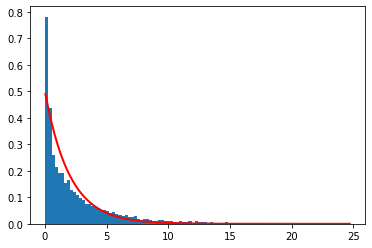

exp with mean 3


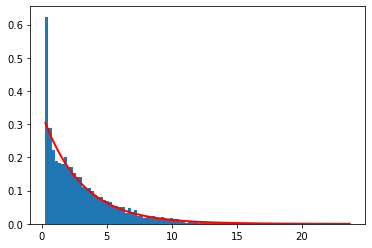

exp with mean 4


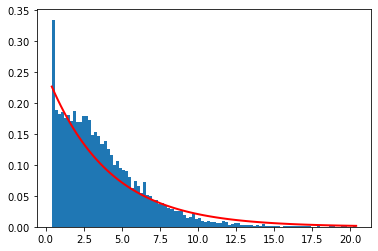

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from model import CVAE
from gen_data import cvae_ds

name = "data/CVAE_exp"
par = np.load(name+"_params.npy", allow_pickle=True).item()

model = CVAE(**par)

model.load_state_dict(torch.load(name+"_model"))

samples = 10000
for mean in np.arange(2,5):
    print(f'exp with mean {mean}')
    res = model.sample_trajectories(samples, torch.tensor(mean))

    count, bins, _ = plt.hist(res.numpy(), 100, density=True)
    plt.plot(bins, 1/mean * np.exp( - (bins / mean) ), linewidth=2, color='r')
    plt.show()

### sample from normal based on big sample (guess mean and variance)

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

from model import CVAE
from config import params
from train import train
from gen_data import cvae_ds

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

par = params.copy()
par.update({
    'input_dim': 1,
    'cond_dim': 5, 
    'epochs': 20,
    'reg': torch.tensor(50),
    'latent_dim': 2,
    'layers': [500,100],
})


m = np.random.uniform(-10,10, par['train_samples'])
s = np.random.uniform(0.1,0.3, par['train_samples'])
X = [np.random.normal(_m,_s, par['cond_dim']) for _m,_s in zip(m,s)]
Y = np.random.normal(m,s)
set0 = cvae_ds(X, Y)
loader = DataLoader(set0, par['batch_size'])

model = CVAE(device=device, **par).to(device)

train(model, loader, device, True, **par)

# save the results
name = "data/CVAE_test_empirical_normal"
torch.save(model.state_dict(), name+"_model")
np.save(name+"_params",par)

cuda
1: L 77.02196 MSE 1.41791 KLD 6.12667
2: L 2.62696 MSE 0.05250 KLD 0.00213
3: L 2.58962 MSE 0.05155 KLD 0.01233
4: L 2.29438 MSE 0.04263 KLD 0.16311
5: L 1.73771 MSE 0.02172 KLD 0.65176
6: L 1.66993 MSE 0.01909 KLD 0.71549
7: L 1.63932 MSE 0.01816 KLD 0.73123
8: L 1.61699 MSE 0.01745 KLD 0.74466
9: L 1.57997 MSE 0.01664 KLD 0.74798
10: L 1.51763 MSE 0.01484 KLD 0.77578
11: L 1.47145 MSE 0.01386 KLD 0.77832
12: L 1.44547 MSE 0.01336 KLD 0.77765
13: L 1.44487 MSE 0.01322 KLD 0.78377
14: L 1.44728 MSE 0.01318 KLD 0.78808
15: L 1.42056 MSE 0.01254 KLD 0.79350
16: L 1.41257 MSE 0.01237 KLD 0.79406
17: L 1.42085 MSE 0.01249 KLD 0.79653
18: L 1.42445 MSE 0.01262 KLD 0.79369
19: L 1.41429 MSE 0.01235 KLD 0.79688
20: L 1.41804 MSE 0.01239 KLD 0.79865


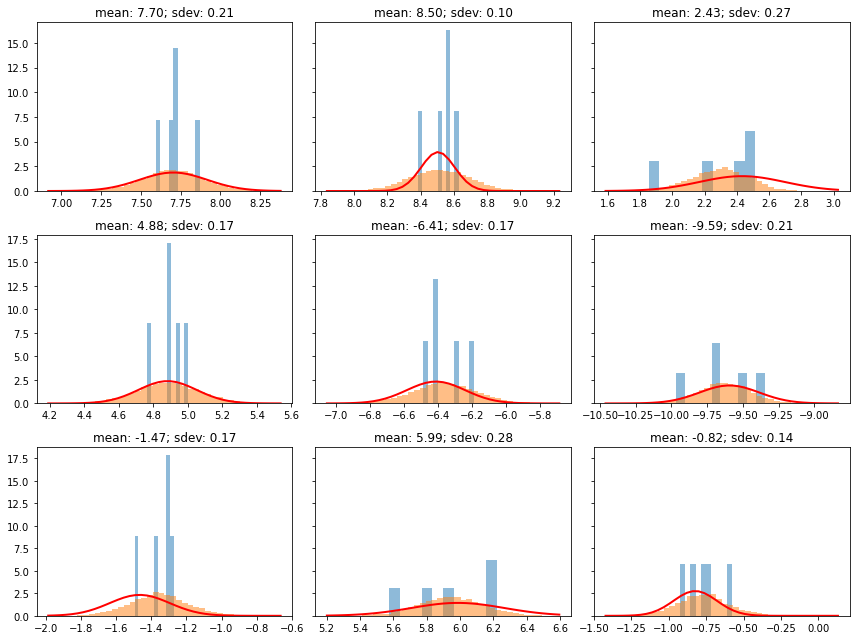

In [36]:
name = "data/CVAE_test_empirical_normal"
par = np.load(name+"_params.npy", allow_pickle=True).item()
model = CVAE(**par)
model.load_state_dict(torch.load(name+"_model"))

nrows, ncols = 3, 3
fig, axs = plt.subplots(nrows, ncols,  
                        figsize=(nrows*4, ncols*3),
                        sharey='row')
for i in range(nrows):
    for j in range(ncols):
        samples = 10000
        mean = np.random.uniform(-10,10)
        sdev = np.random.uniform(0.1,0.3)
        X = torch.tensor(np.random.normal(mean,sdev, par['cond_dim']), dtype=torch.float32)
        res = model.sample_trajectories(samples, X)

        axs[i,j].hist(X.numpy(), density=1, alpha=0.5, label="conditional")
        count, bins, _ = axs[i,j].hist(res.numpy(), 40, alpha=0.5, density=1, label="model prediction")
        axs[i,j].plot(bins, 1/(sdev * np.sqrt(2 * np.pi)) *
                       np.exp( - (bins - mean)**2 / (2 * sdev**2) ),
                 linewidth=2, color='r', label="ground truth")
        axs[i,j].title.set_text("mean: {:.2f}; sdev: {:.2f}".format(mean, sdev))

fig.tight_layout()
plt.show()

## Ornstein Uhlenbeck process

Ornstein-Uhlenbeck process follows the equation:
$$ dx_t = \theta(\mu-x_t)dt + \sqrt{2}\sigma dW_t $$
where $\theta,\mu$ and $\sigma$ are hyperparameters and $W$ is a Wiener process.
The solution is of the form:
$$ x_t = x_0e^{-\theta t} + \mu(1-e^{-\theta t}) + \frac{\sigma e^{-\theta t}}{\sqrt{\theta}} B_{e^{2\theta t}-1} $$
where $B$ is some other Wiener process.

The starting point $x_0$ will be sampled from the invariant distribution of $x$ which is $\mathcal{N}(\mu,{\sigma^2}/{\theta})$ and the trajectories will be approximated using Euler-Maruyama scheme.

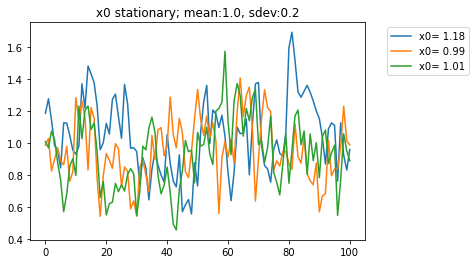

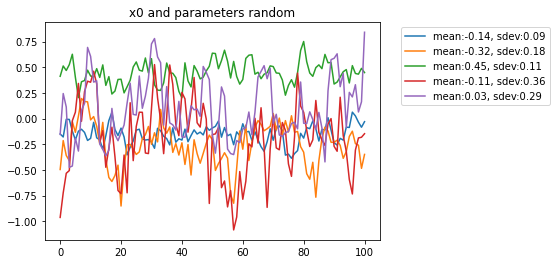

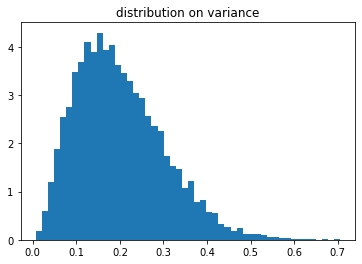

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import gen_data
from config import params

T = 100
num = 3
X0 = gen_data.stationary(**params, size=num)
X = [gen_data.trajectory(x0, T=T, **params) for x0 in X0]
x=range(T+1)
for i in range(num):
    plt.plot(x,X[i], label= "x0= {:.2f}".format(X[i][0]))
    plt.title(f"x0 stationary; mean:{params['mu']}, sdev:{params['sigma']}")
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

for i in range(5):
    mu=np.random.uniform(low=-1,high=1)
    sigma=np.random.beta(a=3,b=12)
    x0 = gen_data.stationary(mu=mu, sigma=sigma)
    X = gen_data.trajectory(x0, T=T, slices=10, mu=mu, sigma=sigma)
    
    plt.plot(x, X, label="mean:{:.2f}, sdev:{:.2f}".format(mu,sigma))
    plt.title("x0 and parameters random")
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.hist(np.random.beta(a=3,b=12, size=10000), bins=50, density=True)
plt.title("distribution on variance")
plt.show()

### OU with varying x0 and fixed parameters

In [2]:
par = params.copy()
par.update({
    'input_dim': 10,
    'cond_dim': 90, 
    'sigma': 1,
})

x0 = gen_data.stationary(size=par['train_samples'], **par)
XY = [gen_data.trajectory(_x0, T=par['input_dim']+par['cond_dim']-1, **par) for _x0 in x0]
X = [xy[:par['cond_dim']] for xy in XY]
Y = [xy[par['cond_dim']:] for xy in XY]

cuda


In [4]:
# save the data
name = "data/CVAE-OU"
np.save(name+"_X", X)
np.save(name+"_Y", Y)
np.save(name+"_params", par)

In [24]:
# load the data
name = "data/CVAE-OU"
X = np.load(name+"_X.npy")
Y = np.load(name+"_Y.npy")
set0 = gen_data.cvae_ds(X, Y)
loader = DataLoader(set0, par['batch_size'])

In [99]:
name = "data/CVAE-OU"
par = np.load(name+"_params.npy", allow_pickle=True).item()
par.update({
    'epochs': 100,
    'batch_size':1000,
    'reg': torch.tensor(10**5),
    'bias': False,
    'latent_dim': 100,
    'layers': [1000,500,200],
    'end_relu': False, 
})


model = CVAE(device=device, **par).to(device)

train(model, loader, device, True, **par)

# save the results
torch.save(model.state_dict(), name+"_model")
np.save(name+"_params", par)

1: L 8988.03320 MSE 0.08987 KLD 0.70567
2: L 3985.83984 MSE 0.03981 KLD 4.93324
3: L 3031.93701 MSE 0.03008 KLD 23.60932
4: L 2921.12817 MSE 0.02884 KLD 37.22578
5: L 2923.01392 MSE 0.02888 KLD 34.60244
6: L 2899.47339 MSE 0.02866 KLD 33.33735
7: L 2871.67017 MSE 0.02840 KLD 31.85101
8: L 2866.38232 MSE 0.02836 KLD 29.88354
9: L 2838.51880 MSE 0.02810 KLD 28.70766
10: L 2853.37451 MSE 0.02825 KLD 28.20390
11: L 2800.37939 MSE 0.02772 KLD 28.72935
12: L 2710.90552 MSE 0.02679 KLD 31.97560
13: L 2068.24341 MSE 0.02016 KLD 52.66039
14: L 1795.83313 MSE 0.01737 KLD 58.34710
15: L 1523.94202 MSE 0.01459 KLD 65.34260
16: L 1455.15820 MSE 0.01392 KLD 63.11921
17: L 1430.61340 MSE 0.01372 KLD 58.36992
18: L 1431.24683 MSE 0.01376 KLD 55.66212
19: L 1451.84326 MSE 0.01398 KLD 54.02577
20: L 1386.00085 MSE 0.01331 KLD 55.41341
21: L 1282.21326 MSE 0.01219 KLD 63.23717
22: L 1164.15625 MSE 0.01099 KLD 64.71177
23: L 1126.37122 MSE 0.01065 KLD 61.59761
24: L 1094.68799 MSE 0.01035 KLD 59.82182
25:

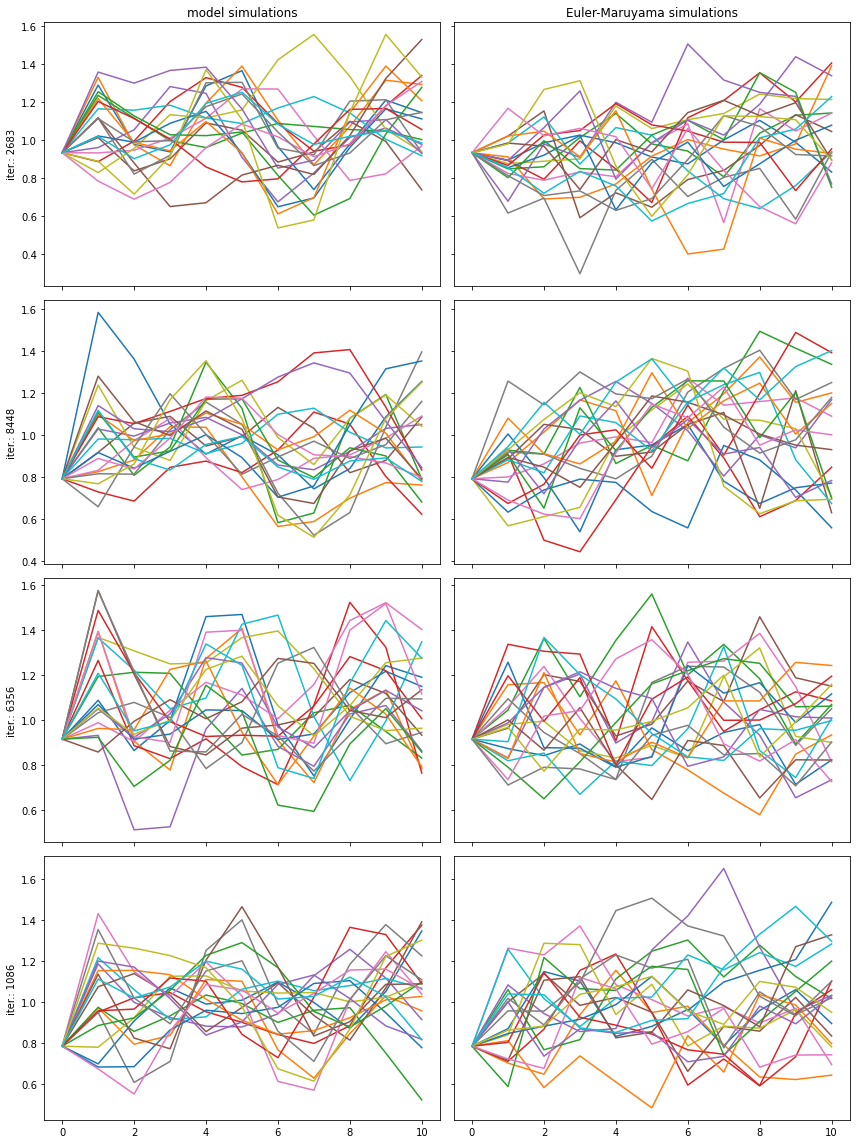

In [101]:
name = "data/CVAE-OU"
X = np.load(name+"_X.npy")
par = np.load(name+"_params.npy", allow_pickle=True).item()
model = CVAE(**par)
model.load_state_dict(torch.load(name+"_model"))


nrows = 4
ncols = 2
samples = 20
x = np.arange(0, 1+par['input_dim'])
I = np.arange(0, par['train_samples'])
np.random.shuffle(I)

fig, axs = plt.subplots(nrows, ncols,  
                        figsize=(nrows*3, nrows*4),
                        sharex='col', sharey='row')

for i in range(nrows):
    res = model.sample_trajectories(samples, torch.tensor(X[I[i]], dtype=torch.float32))

    for j in range(samples):
        axs[i,0].plot(x, np.append(X[I[i]][0], res[j].numpy()))
    
    axs[i,0].set_ylabel(f"iter.: {I[i]}")
    for j in range(samples):
        EM = gen_data.trajectory(X[I[i]][0], T=par['input_dim'], **par)
        axs[i,1].plot(x, EM)
    
axs[0,0].title.set_text("model simulations")
axs[0,1].title.set_text("Euler-Maruyama simulations")

fig.tight_layout()
plt.show()

## Conclusions:

- if conditional variable decodes information about the mean of x, then we may lend in a (local?) minimum $\operatorname{Var}(x)$ by mapping encoder to $\mathcal{N}(0,1)$ and decoder determiistically to $\mathbb{E}x$
- cvae has difficulties with parameters extrapolation
- for multidimensional distributions it is difficult to verify optimality of the result


## Further research directions:

- Bayesian models simulations
- OU with varying parameters
- real data?
- various statistics of the trajectory (Asian option prices etc.)